<a href="https://colab.research.google.com/github/ChristopherLiew/Classifying-Red-Wine-Quality/blob/master/Decision_Trees_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> The Decision Trees Classifier </h1>
<h3> Strengths of the Decision Tree Classifier: </h3>

1.   Generates easy to understand rules, allowing us to identify features of importance and classification criterion.
2.  No need for data to be scaled, since it does not depend on Euclidean distance.

<h3> Weaknesses of the Decision Tree Classifier: </h3>


1.   Prone to overfitting if not properly pruned, hence high variance when tested on new data.
2.   If imbalanced, can be computationally expensive to train. Time complexity can also be very high.




In [0]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.style.use('ggplot') # optional: for ggplot-like style
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve



In [23]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
wine_df = pd.read_csv("/content/gdrive/My Drive/Business Analytics Stuff/BT2101 Group Project/winequality-red.csv")

<h2>Wrangled & Processed Red Wine Quality Dataset</h2>
<p> Tree-based methods are invariant to monotonic transformations, in this case feature scaling, thus we do not need to feature scale. </p>
<p></p>
<p>Additionally, since Tree-based methods utilise entropy and information gain to essentially engage in 'automatic' feature selection, feature selection will not be used. Instead, we will compute the feature importance and iteratively remove any features which have an insignificant amount of feature importance.</p>

In [25]:
# Creating the Binary Target Variable
wine_df["good_quality"] = wine_df["quality"] >= 7

# Target Variable
target = wine_df.loc[:, 'good_quality']
target = target.astype(int)  # 1 = good quality & 0 = other quality
target

# Interaction Terms
final_df = wine_df.drop(columns=['quality', 'good_quality']).copy()
final_df['total acidity'] = final_df['fixed acidity'] + final_df['volatile acidity']
final_df['pH_sulphate'] = final_df['pH'] * final_df['sulphates']

final_df.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,total acidity,pH_sulphate
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,8.10,1.9656
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,8.68,2.1760
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,8.56,2.1190
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,11.48,1.8328
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,8.10,1.9656
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,8.06,1.9656
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,8.50,1.5180
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7.95,1.5933
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,8.38,1.9152
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,8.00,2.6800


<h2>Train-Test Data</h2>
<p> Train: 75% & Test: 25%</p>

In [0]:
X_train, X_test, y_train, y_test = train_test_split(final_df, target, test_size=0.25,random_state=0)

<h2>Hyperparameter Tuning with GridSearchCV & RandomisedSearchCV </h2>

In [27]:
# Decision Tree Classifier
DT_classifier = DecisionTreeClassifier()

# Hyperparameter Tuning with RandomSearchCV & GridSearchCV
# 1. Reduce parameter search soace using RandomSearchCV first
rnd_param = {
    'max_depth': [10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'class_weight': ['balanced_subsample', 'balanced', None]
}

rnd_sr = RandomizedSearchCV(estimator=DT_classifier,
                            param_distributions=rnd_param,
                            scoring="f1_macro",
                            n_iter=50,
                            cv=5,
                            n_jobs=-1)

rnd_sr.fit(X_train, y_train)

print("RandomisedSearchCV Best Params: " + str(rnd_sr.best_params_)) # Optimal Parameters: Max Depth has high variance, results produce range from 10 to 40

# Defer to 2. Grid Search CV
grid_param = {
    'max_depth': [5, 10, 15, 20, 25, 30, 35, 40],
    'class_weight': ['balanced_subsample', 'balanced', None]
}
gd_sr = GridSearchCV(estimator=DT_classifier,
                     param_grid=grid_param,
                     scoring='f1_macro',
                     cv=10,
                     n_jobs=-1)

gd_sr.fit(X_train, y_train)

print("GridSeachCV Best Params: " + str(gd_sr.best_params_ ))# Final Optimal Parameters: {'class_weight': None, 'max_depth': 25}
print("GridSearchCV Best Score: " + str(np.round(gd_sr.best_score_,3)))  # 0.7644

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 33 is smaller than n_iter=50. Running 33 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RandomisedSearchCV Best Params: {'max_depth': 10, 'class_weight': None}
GridSeachCV Best Params: {'class_weight': None, 'max_depth': 40}
GridSearchCV Best Score: 0.764


<h2>Training the Decision Tree Classifier</h2>

In [0]:
classifier = DecisionTreeClassifier(criterion='gini', max_depth=25,random_state=0)  # Use Entropy as measure of disorder
classifier.fit(X_train, y_train)

#Predictions
y_pred = classifier.predict(X_test)

<h2>Evaluating the Decision Tree</h2>

<h3>Classification Report</h3>

In [29]:
report = classification_report(y_test, y_pred, output_dict = True)
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
0,0.964286,0.912676,0.937771,355.0000
1,0.515625,0.733333,0.605505,45.0000
accuracy,0.892500,0.892500,0.892500,0.8925
macro avg,0.739955,0.823005,0.771638,400.0000
weighted avg,0.913811,0.892500,0.900391,400.0000


<h3>ROC & AUC</h3>

Decision Trees: ROC AUC=0.823


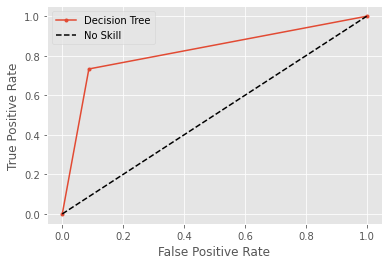

In [31]:
# prediction probabilities
dt_probs = classifier.predict_proba(X_test)
ns_probs = [0 for _ in range(len(y_test))]
# keep probabilities for the positive outcome only
dt_probs = dt_probs[:, 1]
# calculate scores
dt_auc = roc_auc_score(y_test, dt_probs)
ns_auc = roc_auc_score(y_test, ns_probs) # 0.5
# summarize scores
print('Decision Trees: ROC AUC=%.3f' % (dt_auc))
# calculate ROC curves
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
# plot the ROC curve for the Decision Tree Classifier
plt.plot(dt_fpr, dt_tpr, marker='.', label='Decision Tree')
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill', color = "black")
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

<h3>Precision Recall Curve</h3>

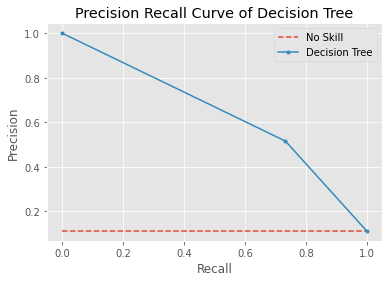

In [40]:
dt_probs = DT_classifier.predict_proba(X_test)
dt_probs = dt_probs[:, 1] # Keep probability predictions for good quality (=1) class only
precisions, recalls, _ = precision_recall_curve(y_test, dt_probs)

# Plot PR-Curve
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recalls, precisions, marker='.', label='Decision Tree')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# annotate optimised model's recall and precision
# Title
plt.title("Precision Recall Curve of Decision Tree")
# show the plot
plt.show()

<h2>Feature Importance (Testing our Hypotheses)</h2>
<p> https://stackoverflow.com/questions/49170296/scikit-learn-feature-importance-calculation-in-decision-trees </p>
<p> https://medium.com/the-artificial-impostor/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3</p>
<p>Feature Importance is measured by GINI importance which is in turn calculated by the Mean Decrease in Impurity = the sum over the number of splits (across all tress) that include the feature, proportionally to the number of samples it splits.</p>

In [35]:
for name, importance in zip(final_df.columns, classifier.feature_importances_):
...     print(name, "=", importance)

fixed acidity = 0.029761108468195466
volatile acidity = 0.13222860584730642
citric acid = 0.03966502512966093
residual sugar = 0.08259369127886351
chlorides = 0.07282423378596986
free sulfur dioxide = 0.08857210854527514
total sulfur dioxide = 0.048009602834598056
density = 0.022236208742685056
pH = 0.07505486762749929
sulphates = 0.11179546393827455
alcohol = 0.21194369862633447
total acidity = 0.049953209312981785
pH_sulphate = 0.03536217586235546


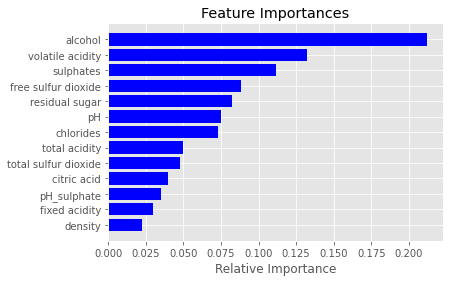

In [36]:
features = final_df.columns
importances = classifier.feature_importances_
indices = np.argsort(importances)

#Graphing it
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

<h1> Permutation Importance </h1>

In [34]:
# Permutation Importance (eli5)
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance
DT_classifier = DecisionTreeClassifier(criterion="gini", random_state=0, max_depth=25)
DT_classifier.fit(X_train, y_train)
perm = PermutationImportance(DT_classifier, random_state=1, scoring="f1_macro", n_iter=10).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist()) # See on Jupyter Notebook

Weight,Feature
0.1892 ± 0.0532,alcohol
0.1101 ± 0.0397,volatile acidity
0.0706 ± 0.0163,citric acid
0.0544 ± 0.0323,free sulfur dioxide
0.0520 ± 0.0292,total sulfur dioxide
0.0515 ± 0.0163,sulphates
0.0434 ± 0.0178,pH
0.0425 ± 0.0174,chlorides
0.0278 ± 0.0195,residual sugar
0.0106 ± 0.0000,fixed acidity


<p> All features are important in classifying Quality Red Wines.</p>
<p>Thus, no further feature selection is necessary for the Decision Tree Classifier.</p>